<h1><font color="#113D68" size=6>Deep Learning Avanzado con Python y Keras</font></h1>
<h1><font color="#113D68" size=5>Leandro Martín Rognoni</font></h1>

<br><br>
<div style="text-align: right">
 
</div>

<a id="section0"></a>
# <font color="#004D7F" size=5> Contexto</font>

* Definición de un grafo
* Entrenamiento de una red
* Capas de la red

* MNIST: la base de datos de números nos servirá para definir los conceptos básicos. 


In [23]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import keras

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
SEED = 1000
np.random.seed(SEED)
tf.random.set_seed(SEED)

<a id="section2.1"></a>
# <font color="#004D7F" size=5> MNIST</font>

MNIST es una base de datos que consta de imágenes de tamaño 28x28 de dígitos escritos a mano que van del 0 al 9 y que han sido etiquetadas con el número representado en la imagen. Inicialmente, tenemos 60.000 imágenes en el conjunto de train y 10.000 en el de test, sin embargo, el conjunto de train lo vamos a partir en entrenamiento y validación, siguiendo las prácticas anteriores.

In [52]:
# keras ya nos da una función con la que cargar esta base de datos
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, y_train_valid, test_size=0.1, random_state=SEED, stratify=y_train_valid)

print("Dimensiones del conjunto de características de train: {}".format(x_train.shape))
print("Dimensiones del conjunto de etiquetas de train: {}".format(y_train.shape))
print()
print("Dimensiones del conjunto de características de valid: {}".format(x_valid.shape))
print("Dimensiones del conjunto de etiquetas de valid: {}".format(y_valid.shape))
print()
print("Dimensiones del conjunto de características de test: {}".format(x_test.shape))
print("Dimensiones del conjunto de etiquetas de test: {}".format(y_test.shape))

Dimensiones del conjunto de características de train: (54000, 28, 28)
Dimensiones del conjunto de etiquetas de train: (54000,)

Dimensiones del conjunto de características de valid: (6000, 28, 28)
Dimensiones del conjunto de etiquetas de valid: (6000,)

Dimensiones del conjunto de características de test: (10000, 28, 28)
Dimensiones del conjunto de etiquetas de test: (10000,)


In [53]:
def show_images(images, gray=True):
    fig=plt.figure(figsize=(8, 8))
    index = np.random.randint(len(images), size=100)
    for i in range(100):
        fig.add_subplot(10, 10, i+1)
        plt.axis('off')
        if gray:
            color = 'gray'
        else:
            color = None
        plt.imshow(images[index[i]], cmap=color)
    plt.show()

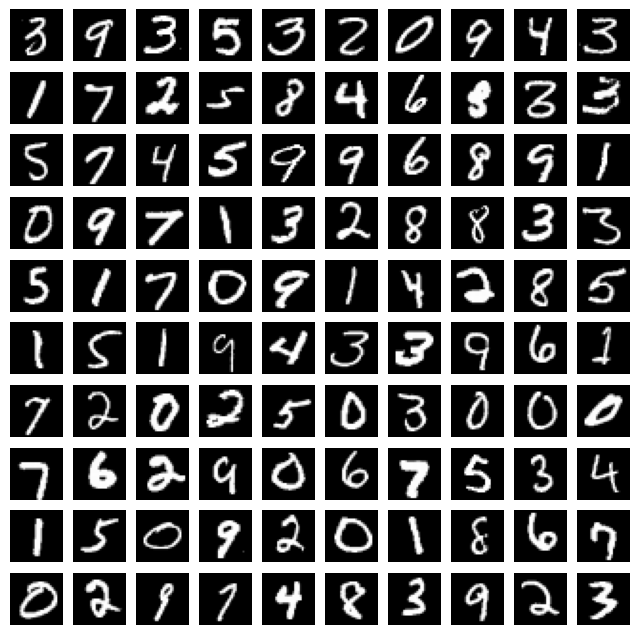

In [55]:
show_images(x_train)

Es mejor tener las imágenes como un vector de características, por lo que vamos a "aplanar" nuestras imágenes de train y test en una matriz de 2 dimensiones. Además, vamos a normalizar los valores entre 0 y 1, para ello dividimos entre 255, ya que los valores en escala de grises van del 0 al 255.

Al igual que en todos los problemas multiclase en deep learning, hay que convertir los valores a codificación **one hot** para poder trabajar con ellos. Lo vamos a dejar ya preparado con la función `to_categorical` de `keras.utils`.

In [56]:
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],-1)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
print("Dimensiones del conjunto de características de train aplanadas: {}".format(x_train.shape))
print("Dimensiones del conjunto de etiquetas de train en one hot: {}".format(y_train.shape))
print()

x_valid = x_valid.astype('float32')
x_valid /= 255
x_valid = x_valid.reshape(x_valid.shape[0],-1)
y_valid = keras.utils.to_categorical(y_valid, num_classes=10)
print("Dimensiones del conjunto de características de train aplanadas: {}".format(x_valid.shape))
print("Dimensiones del conjunto de etiquetas de train en one hot: {}".format(y_valid.shape))
print()


x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0],-1)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
print("Dimensiones del conjunto de características de test aplanadas: {}".format(x_test.shape))
print("Dimensiones del conjunto de etiquetas de test en one hot: {}".format(y_test.shape))

Dimensiones del conjunto de características de train aplanadas: (54000, 784)
Dimensiones del conjunto de etiquetas de train en one hot: (54000, 10)

Dimensiones del conjunto de características de train aplanadas: (6000, 784)
Dimensiones del conjunto de etiquetas de train en one hot: (6000, 10)

Dimensiones del conjunto de características de test aplanadas: (10000, 784)
Dimensiones del conjunto de etiquetas de test en one hot: (10000, 10)


<a id="section2.2"></a>
# <font color="#004D7F" size=5>Creación de una Red Neuronal Secuencial para Clasificación Multiclase </font>

In [458]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(15, input_shape=(784,), activation='relu')) # Primera capa oculta
#Se agregó dropout para desactivar neuronas para prevenir sobreajuste 
model.add(Dropout(0.01))

model.add(Dense(15, activation='relu')) # Segunda capa oculta
model.add(Dropout(0.01))

model.add(Dense(10, activation='softmax')) # Salida (10 clases)

En la primera capa se ha añadido `input_shape`. Esto hay que hacerlo obligatoriamente en la primera y sólo en la primera capa de todos los modelos, indicando el tamaño de la entrada. Este valor es 784 (28*28) que corresponde con el número de pixels de las imágenes de MNIST.

<a id="section2.3"></a>
# <font color="#004D7F" size=5>Entrenamiento</font>

Se define el aprendizaje, es decir, la función de perdida (`loss`) y el optimizador. Esta función tiene como parámetros de entrada `loss` y `optimizer`, para usar una función concreta con sus valores por defecto, o un objeto que defina la función. Además, podemos añadir diferentes métricas que se calcularán durante el proceso de aprendizaje y de validación.


In [459]:
# Ejemplo con las funciones predefinidas y con valores por defecto
model.compile(loss='categorical_crossentropy', optimizer='sgd')
# Podemos añadir métricas  
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])

Ajustar automáticamente la tasa de aprendizaje "ExponentialDecay"

In [460]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    #staircase=True,
    decay_rate=1e-6)

In [461]:
from keras.optimizers import SGD
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

"Fit"tiene como parámetros de entrada la matriz de características, las clases, el número de epocas, tamaño del batch y devuelve un objeto History con información sobre el entrenamiento, como el `loss` obtenido o las `metrics` que hayamos indicado en `compile`.

In [462]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=2048)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.3788 - loss: 1.7452 - val_acc: 0.8432 - val_loss: 0.5278
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8481 - loss: 0.5014 - val_acc: 0.8872 - val_loss: 0.3710
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8850 - loss: 0.3808 - val_acc: 0.9045 - val_loss: 0.3196
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8996 - loss: 0.3337 - val_acc: 0.9118 - val_loss: 0.2945
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9072 - loss: 0.3053 - val_acc: 0.9218 - val_loss: 0.2750
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9136 - loss: 0.2857 - val_acc: 0.9248 - val_loss: 0.2625
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9173 - loss: 0.2724 - val_acc: 0.9292 - val_loss: 0.2515
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9205 - loss: 0.2615 - val_acc: 0.9320 - val_loss: 0.2437
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9231 - loss:

In [287]:
print(history.history.keys())

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


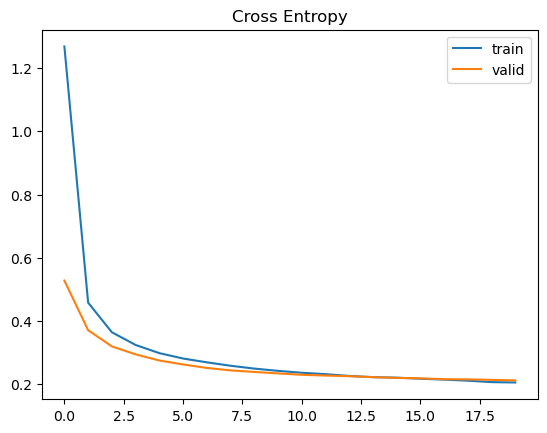

In [463]:
# Cross entropy es una función de pérdida que compara la distribución de probabilidad predicha por el modelo con la distribución real de los datos.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
# Se representan dos curvas a lo largo de las epocas del entrenamiento del modelo:

plt.show()

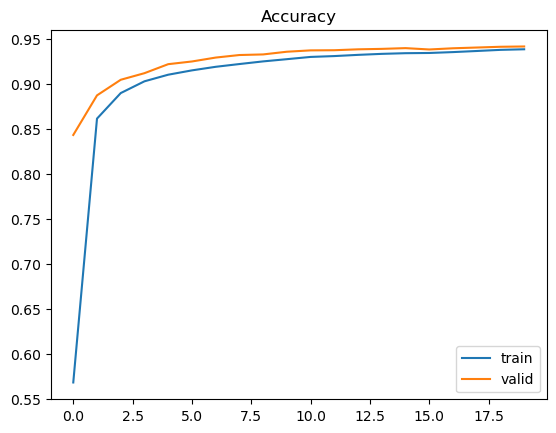

In [464]:
#   la evolución del accuracy a través de los epocas
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

<a id="section2.4"></a>
# <font color="#004D7F" size=5>Predicción y test</font>


* `predict`: la salida de la última capa.
* `predict_proba`: las probabilidades normalizadas de las salidas (si nuestra red ya incluye softmax al final, el resultado es el mismo que la función anterior).
* `predict_class`: la clase predicha 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


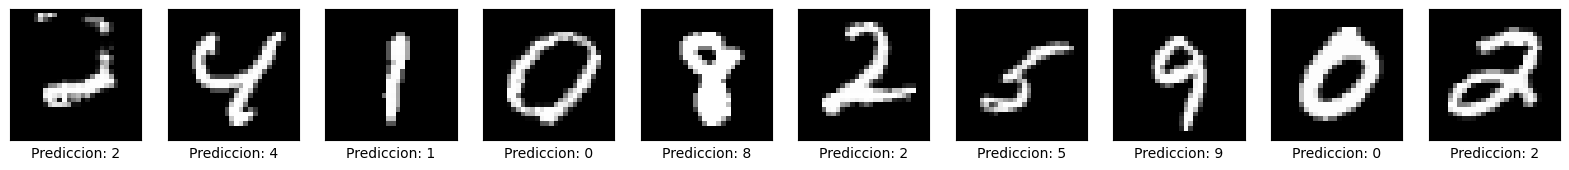

In [470]:
#predictions = model.predict_classes(x_test)

#si la probabilidad es mayor que 0.5,se considera que el ejemplo pertenece a la clase positiva (1),
# y si es menor o igual a 0.5, se considera que pertenece a la clase negativa (0).
predictions = (model.predict(x_test) > 0.5).astype("int32")
#Se utiliza para obtener la clase con la probabilidad más alta para cada ejemplo
predictions = np.argmax(predictions, axis=1)
# Mostramos algunos digitos con las clases predichas
fig=plt.figure(figsize=(20, 8))
index = np.random.randint(len(x_test), size=10)
for i in range(10):
    fig_i = fig.add_subplot(1, 10, i+1)
    fig_i.set_xticks(())
    fig_i.set_yticks(())
    fig_i.set_xlabel("Prediccion: {}".format(predictions[index[i]]))
    plt.imshow(x_test[index[i]].reshape((28,28)), cmap='gray')
plt.show()

Obtener algunos resultados sobre el test, utilizamos `evaluate`, que nos devolverá los valores `loss` y las `metrics` para un conjunto de test.

In [471]:
score = model.evaluate(x_test, y_test)
print()
print("Loss: {}\nAccuracy: {}".format(score[0],score[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.9306 - loss: 0.2201

Loss: 0.18935228884220123
Accuracy: 0.9420999884605408
